In [1]:
#!pip uninstall torch torchvision torchaudio -y
!pip install torch torchvision torchaudio
!pip install jsonlines
!pip install transformers
!pip install tqdm scikit-learn datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.4 MB/s eta 0:00:00


In [2]:
import torch
print(torch.__version__)
import jsonlines
import numpy as np
import transformers
import pandas as pd
import pickle as pkl
from torch import nn
from tqdm import tqdm
from os.path import join
import multiprocessing as mp
from importlib import reload
from collections import Counter
from datasets import load_dataset
from torch.utils.data import Dataset
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
from transformers import (WEIGHTS_NAME,
                          BertConfig, BertForSequenceClassification, BertTokenizer,
                          XLMConfig, XLMForSequenceClassification, XLMTokenizer,
                          DistilBertConfig, DistilBertForSequenceClassification, DistilBertTokenizer,
                          RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer)
from transformers import BertPreTrainedModel, BertModel, AdamW, get_linear_schedule_with_warmup, AutoTokenizer, AutoModel

2.1.0+cu118


In [92]:
# @title load dataset from local

df_train = pd.read_csv("/content/drive/MyDrive/11711/Project_4/translated_full/trans-cn-train.csv")

df_valid = pd.read_csv("/content/drive/MyDrive/11711/Project_4/translated_full/valid_translated_full_v2.csv")

df_test = pd.read_csv("/content/drive/MyDrive/11711/Project_4/translated_full/test_split_translated_full.csv")

In [93]:
df_train.head()

,TV_ID,Dialogue_ID,Utterance_ID,Speaker,Gender,Age,Neuroticism,Extraversion,Openness,Agreeableness,Conscientiousness,Scene,FacePosition_LU,FacePosition_RD,Sentiment,Emotion,DA,Utterance,translation
0,1,01_000,01_000_000,童文洁,female,middle-aged,high,high,low,low,high,other-venue,108_136,156_202,neutral,neutral,greeting,真巧,So coincidentally
1,1,01_000,01_000_001,童文洁,female,middle-aged,high,high,low,low,high,other-venue,193_144,253_197,neutral,neutral,greeting,车没事了,The car is fine
2,1,01_000,01_000_002,刘静,female,middle-aged,low,high,high,high,high,other-venue,0_0,0_0,neutral,neutral,answer,是你呀 没事了没事 谢谢你,"It's you, it's okay, thank you"
3,1,01_000,01_000_003,童文洁,female,middle-aged,high,high,low,low,high,other-venue,0_0,0_0,neutral,neutral,question,没事没事 你也去春风,"It's okay, you can go to Chunfeng too"
4,1,01_001,01_001_000,刘静,female,middle-aged,low,high,high,high,high,other-venue,0_0,0_0,neutral,neutral,answer,对,right


In [94]:
# @title Modify the dataframe to only include English text
# exclude those rows that transaltion failed or are pure numbers

df_train = df_train.loc[df_train['translation'].str.contains('[A-Za-z]')].reset_index(drop=True)
df_test = df_test.loc[df_test['translation'].str.contains('[A-Za-z]')].reset_index(drop=True)
df_valid = df_valid.loc[df_valid['translation'].str.contains('[A-Za-z]')].reset_index(drop=True)

In [95]:
# @title try to group by speaker and emotion in a row

def joinTextBySpeakerAndEmotion(df):

  # Initialize the group column
  df['group'] = 0
  current_group = 1

  # Iterate through the DataFrame
  for i in range(len(df) - 1):
      df.at[i, 'group'] = current_group
      # print(current_group)

      # Check if the next row should be in the same group
      if df.at[i, 'Speaker'] != df.at[i + 1, 'Speaker'] or df.at[i, 'Emotion'] != df.at[i + 1, 'Emotion']:
          current_group += 1

  # Assign group number to the last row
  df.at[len(df) - 1, 'group'] = current_group

  # Ensure all data in 'translation' is string type
  df['translation'] = df['translation'].astype(str)

  # Now group by 'group', 'Speaker', and 'Emotion', and combine 'translation'
  # grouped = df.groupby(['group', 'Speaker', 'Emotion']).agg({
  grouped = df.groupby(['group']).agg({
      'translation': lambda x: ', '.join(x) + '.',
      'Utterance' : lambda y: ', '.join(y) + '.',
      # For other columns, you can decide how to aggregate them
      'TV_ID': 'first',
      'Dialogue_ID': 'first',
      'Utterance_ID': 'first',
      'Speaker': 'first',
      'Emotion': 'first'
      # ... handle other columns as needed
  }).reset_index(drop=True)

  # The resulting DataFrame
  return grouped

df_train = joinTextBySpeakerAndEmotion(df_train)
df_valid = joinTextBySpeakerAndEmotion(df_valid)
df_test = joinTextBySpeakerAndEmotion(df_test)

In [96]:
df_test[30:60]

,translation,Utterance,TV_ID,Dialogue_ID,Utterance_ID,Speaker,Emotion
30,I still use to find a taxi and take a taxi..,还用找 直接坐计程车去不就好了.,27,27_006,27_006_001,林宛瑜,depress
31,"You can find my sister, She is super enthusias...","你可以找我姐姐, 她这人超热心.",27,27_006,27_006_002,陆展博,neutral
32,Maybe you can help you.,说不定能帮上你.,27,27_006,27_006_004,陆展博,relief
33,Really.,真的吗.,27,27_006,27_006_005,林宛瑜,happy
34,"My sister is a university teacher, She should ...","我姐姐是大学老师, 本来她应该今天来接我的.",27,27_006,27_006_006,陆展博,neutral
35,I heard that she is going to be a general dire...,"可听说她要做一场什么婚礼的总导演, 我就只能自己坐车过去.",27,27_006,27_006_008,陆展博,depress
36,"director, Then she must be amazing.","导演, 那她一定很厉害吧.",27,27_007,27_007_000,林宛瑜,happy
37,"I haven't seen her for a long time, In my impr...","我也好久没见她了, 在我的印象里, 记忆最深刻的就是她的眼睛明亮、睿智, 还有他的手纤细温暖...",27,27_007,27_007_002,陆展博,neutral
38,Hello.,您好.,27,27_008,27_008_000,曾小贤,neutral
39,Teacher Zeng?.,曾老师吗.,27,27_008,27_008_001,其他,happy


In [56]:
# Creating a new 'id' column by combining 'TV_ID', 'Dialogue_ID', and 'Utterance_ID'
df_train['id'] = df_train['TV_ID'].astype(str) + '_' + df_train['Dialogue_ID'] + '_' + df_train['Utterance_ID']

# Selecting only the required columns
new_df = df_train[['translation', 'Emotion', 'id']]
new_df = new_df.copy()
new_df.columns = ['text', 'labels', 'id']

# Now new_df has the structure similar to 'go_emotions' dataset
print(new_df.head())

                                     text   labels                   id
0     So coincidentally, The car is fine.  neutral  1_01_000_01_000_000
1         It's you, it's okay, thank you.  neutral  1_01_000_01_000_002
2  It's okay, you can go to Chunfeng too.  neutral  1_01_000_01_000_003
3                                  right.  neutral  1_01_001_01_001_000
4                Your child is also here.  neutral  1_01_001_01_001_001


In [9]:
new_df

,text,labels,id
0,"So coincidentally, The car is fine.",neutral,1_01_000_01_000_000
1,"It's you, it's okay, thank you.",neutral,1_01_000_01_000_002
2,"It's okay, you can go to Chunfeng too.",neutral,1_01_000_01_000_003
3,right.,neutral,1_01_001_01_001_000
4,Your child is also here.,neutral,1_01_001_01_001_001
...,...,...,...
46570,"no see for a few days, Your ideological consci...",neutral,26_26_265_26_265_000
46571,"Ding Xiang, can you promise me that you will s...",neutral,26_26_265_26_265_002
46572,"Who am I to you?, Why should I promise you.",neutral,26_26_265_26_265_005
46573,How can I leave if you don't promise me?.,neutral,26_26_265_26_265_007


In [57]:
new_df['labels'].unique()

array(['neutral', 'relaxed', 'anger', 'depress', 'disgust', 'nervousness',
       'confusion', 'annoyance', 'disappointment', 'grief', 'curiosity',
       'disapproval', 'surprise', 'worried', 'fear', 'happy',
       'astonished', 'embarrassment', 'remorse', 'grateful', 'pride',
       'excitement', 'relief', 'gratitude', 'joy', 'love', 'caring',
       'sadness', 'admiration', 'realization', 'approval', 'desire',
       'amusement', 'optimism'], dtype=object)

In [58]:
# @title perpare similar dataframe for df_test and df_valid (trunc and extract features)
# Creating a new 'id' column by combining 'TV_ID', 'Dialogue_ID', and 'Utterance_ID'
df_valid['id'] = df_valid['TV_ID'].astype(str) + '_' + df_valid['Dialogue_ID'] + '_' + df_valid['Utterance_ID']

# Selecting only the required columns
new_df_valid = df_valid[['translation', 'Emotion', 'id']]
new_df_valid = new_df_valid.copy()
new_df_valid.columns = ['text', 'labels', 'id']

# Now new_df has the structure similar to 'go_emotions' dataset
print(new_df_valid.head())



df_test['id'] = df_test['TV_ID'].astype(str) + '_' + df_test['Dialogue_ID'] + '_' + df_test['Utterance_ID']

# Selecting only the required columns
new_df_test = df_test[['translation', 'Emotion', 'id']]
new_df_test = new_df_test.copy()
new_df_test.columns = ['text', 'labels', 'id']

# Now new_df has the structure similar to 'go_emotions' dataset
print(new_df_test.head())

                                                text      labels  \
0                What's wrong, Did you hit the car?.  astonished   
1  Hit you, I'm going to fall asleep in this bloc...     depress   
2             Do you think your saliva is on my car.     disgust   
3  Don't make trouble, I just dreamed that you bl...   confusion   
4  How much he gives, I can tell you that the wei...     relaxed   

                     id  
0  32_32_000_32_000_000  
1  32_32_000_32_000_002  
2  32_32_000_32_000_005  
3  32_32_000_32_000_006  
4  32_32_000_32_000_007  
                                      text      labels                    id
0                    It's okay, thank you.     neutral  27_27_000_27_000_000
1                       It doesn't matter.     worried  27_27_000_27_000_002
2                        Hello, It's okay.  astonished  27_27_000_27_000_003
3  Borrow you here to hide, Don't, right?.     disgust  27_27_000_27_000_005
4                     You step on my feet.     wor

In [101]:
len(new_df_test)

16070

In [63]:
# @title transform the labels to the matched version to GoEmotions Labels
# Define the mapping
matching_updated = {
'sadness': ['sadness'],
'happy': ["joy"],
'grateful': ["gratitude"],
'relaxed': ["relief"],
'admiration':["admiration"],
'optimism': ['optimism'],
'love': ['love'],
'neutral': ["neutral"],
'anger': ["anger", "annoyance"],
'fear': ["fear"],
'depress': ["grief"],
'disgust': ["disgust"],
'astonished': ["surprise"],
'worried': ["nervousness", "disapproval"],
'confusion': ['confusion'],
'embarrassment':['embarrassment'],
'remorse':['remorse'],
'disapproval':['disapproval'],
'amusement': ['amusement'],
'approval':['approval'],
'caring':['caring'],
'curiosity':['curiosity'],
'desire':['desire'],
'disappointment':['disappointment'],
'excitement':['excitement'],
'pride':['pride'],
'realization':['realization'],
'nervousness':['nervousness'],
'annoyance':['annoyance'],
'gratitude':['gratitude'],
'grief':['grief'],
'joy': ['joy'],
'relief':['relief'],
'surprise':['surprise']
}

# Function to transform the labels
def transform_label(label):
    if label in matching_updated:
        return ', '.join(matching_updated[label])
    return label

# Apply the function to the 'Emotion' column
new_df['labels'] = new_df['labels'].apply(transform_label)

new_df_valid['labels'] = new_df_valid['labels'].apply(transform_label)

new_df_test['labels'] = new_df_test['labels'].apply(transform_label)

In [13]:
new_df_valid

,text,labels,id
0,"What's wrong, Did you hit the car?.",surprise,32_32_000_32_000_000
1,"Hit you, I'm going to fall asleep in this bloc...",grief,32_32_000_32_000_002
2,Do you think your saliva is on my car.,disgust,32_32_000_32_000_005
3,"Don't make trouble, I just dreamed that you bl...",confusion,32_32_000_32_000_006
4,"How much he gives, I can tell you that the wei...",relief,32_32_000_32_000_007
...,...,...,...
6241,Also let me draw a picture of him.,embarrassment,45_45_241_45_241_011
6242,I have made trouble for me for a long time for...,remorse,45_45_241_45_241_012
6243,"Later, it's gone.",disapproval,45_45_241_45_241_013
6244,Now I see that painting cold.,remorse,45_45_241_45_241_014


In [14]:
new_df_test

,text,labels,id
0,"It's okay, thank you.",neutral,27_27_000_27_000_000
1,It doesn't matter.,"nervousness, disapproval",27_27_000_27_000_002
2,"Hello, It's okay.",surprise,27_27_000_27_000_003
3,"Borrow you here to hide, Don't, right?.",disgust,27_27_000_27_000_005
4,You step on my feet.,"nervousness, disapproval",27_27_000_27_000_007
...,...,...,...
16065,"This is absolutely impossible for me, I mainly...",disgust,37_37_225_37_225_009
16066,"Ma Li, you don't have much time, you don't nee...","anger, annoyance",37_37_225_37_225_012
16067,Just cancel it.,surprise,37_37_225_37_225_020
16068,right.,"anger, annoyance",37_37_226_37_226_000


In [68]:
# @title transform labels from text into index
import pandas as pd

# Assuming your DataFrame is named df

# Define the id2label dictionary
id2label = {
    0: "admiration", 1: "amusement", 2: "anger", 3: "annoyance", 4: "approval", 5: "caring",
    6: "confusion", 7: "curiosity", 8: "desire", 9: "disappointment", 10: "disapproval",
    11: "disgust", 12: "embarrassment", 13: "excitement", 14: "fear", 15: "gratitude",
    16: "grief", 17: "joy", 18: "love", 19: "nervousness", 20: "optimism", 21: "pride",
    22: "realization", 23: "relief", 24: "remorse", 25: "sadness", 26: "surprise", 27: "neutral"
}

# Create a reverse mapping from label to index
label2id = {v: k for k, v in id2label.items()}

# Function to convert labels to indices
def labels_to_indices(labels):
    return [label2id[label] for label in labels.split(", ") if label in label2id]

# Apply the function to the 'labels' column
new_df['label_indices'] = new_df['labels'].apply(labels_to_indices)
new_df_valid['label_indices'] = new_df_valid['labels'].apply(labels_to_indices)
new_df_test['label_indices'] = new_df_test['labels'].apply(labels_to_indices)

# Display the modified DataFrame
print(new_df.head())
print(new_df_valid.head())
print(new_df_test.head())


                                     text   labels                   id  \
0     So coincidentally, The car is fine.  neutral  1_01_000_01_000_000   
1         It's you, it's okay, thank you.  neutral  1_01_000_01_000_002   
2  It's okay, you can go to Chunfeng too.  neutral  1_01_000_01_000_003   
3                                  right.  neutral  1_01_001_01_001_000   
4                Your child is also here.  neutral  1_01_001_01_001_001   

  label_indices  
0          [27]  
1          [27]  
2          [27]  
3          [27]  
4          [27]  
                                                text     labels  \
0                What's wrong, Did you hit the car?.   surprise   
1  Hit you, I'm going to fall asleep in this bloc...      grief   
2             Do you think your saliva is on my car.    disgust   
3  Don't make trouble, I just dreamed that you bl...  confusion   
4  How much he gives, I can tell you that the wei...     relief   

                     id label_indices 

In [69]:
# @title roberta config and tokenizer
roberta_config = RobertaConfig.from_pretrained('roberta-base',
                                      num_labels=len(id2label),
                                      finetuning_task='CPED',
                                      cache_dir=None,
                                      output_attentions=False,
                                      output_hidden_states=False)

tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=False)

In [70]:
# @title prepare dataset
class emotionDataset(Dataset):
    """Class to load the dataset and get batches of paras"""

    def __init__(self, list_data,
                 tokenizer, max_length):

        self.tokenizer = tokenizer
        self.max_length = max_length
        self.data = list_data
        self.pad_token = 1

    def __len__(self):
        """Return length of dataset."""
        return self.data.__len__()

    def __getitem__(self, i):
        """Return sample from dataset at index i."""
        # example = self.data[i]
        example = self.data.iloc[i]
        inputs = self.tokenizer.encode_plus(example['text'],
                                            add_special_tokens=True,
                                            truncation=True,
                                            max_length=self.max_length)

        input_ids = inputs["input_ids"]
        input_ids = input_ids[:self.max_length]
        attention_mask = [1] * len(input_ids)

        padding_length = self.max_length - len(input_ids)
        input_ids = input_ids + ([self.pad_token] * padding_length)
        attention_mask = attention_mask + ([0] * padding_length)

        assert len(input_ids) == self.max_length, "Error with input length {} vs {}".format(len(input_ids), self.max_length)

        # nli_label = example['labels'][0]
        nli_label = example['label_indices'][0]

        return_dict = {'input_ids':torch.LongTensor(input_ids),
                       'attention_mask':torch.LongTensor(attention_mask),
                       'labels': torch.LongTensor([nli_label])}

        return return_dict

In [71]:
train_dataset = emotionDataset(list_data=new_df,
                               tokenizer=tokenizer,
                               max_length=200)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,
                          num_workers=mp.cpu_count())

In [72]:
train_dataset

In [105]:
valid_df = new_df_valid
test_df = new_df_test

In [106]:
# Validation dataset
val_dataset = emotionDataset(list_data=valid_df,
                             tokenizer=tokenizer,
                             max_length=200)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False,
                        num_workers=mp.cpu_count()) # batch_size 32 to 64

# Test dataset
test_dataset = emotionDataset(list_data=test_df,
                               tokenizer=tokenizer,
                               max_length=200)
test_loader = DataLoader(test_dataset, batch_size=64,
                         shuffle=False, num_workers=mp.cpu_count())

In [108]:
# @title example batch shape
example_batch = next(iter(train_loader))
example_batch['input_ids'].shape, example_batch['attention_mask'].shape, example_batch['labels'].shape

(torch.Size([64, 200]), torch.Size([64, 200]), torch.Size([64, 1]))

In [81]:
# @title load model

saved_project3_path='/content/drive/MyDrive/11711/Project_4/project3_model_epoch5.pt'

loaded_model = RobertaForSequenceClassification(config=roberta_config).cuda()
loaded_model = nn.DataParallel(loaded_model.cuda())

# Load the state dictionary
state_dict = torch.load(saved_project3_path, map_location=torch.device('cpu'))

# Apply the state dictionary to the model
loaded_model.load_state_dict(state_dict)

model = loaded_model

In [82]:
import os
from google.colab import drive
drive.mount('/content/drive')

model_save_path = '/content/drive/MyDrive/11711/Project_4/Checkpoints_train_join_full'  # Replace with your desired path
os.makedirs(model_save_path, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [83]:
# @title model parameter config
args = {'weight_decay':1e-5, # changed from 0.0
        'learning_rate':2e-5, # changed from 2e-5
        'epochs':5,
        'gradient_accumulation_steps':1,
        'adam_epsilon':1e-8}
args['t_total'] = len(train_loader) // args['gradient_accumulation_steps'] * args['epochs']
args['warmup_steps'] = int(0.10*args['t_total'])

In [84]:
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
         'weight_decay': args['weight_decay']},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
optimizer = AdamW(optimizer_grouped_parameters, lr=args['learning_rate'], eps=args['adam_epsilon'])
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=args['warmup_steps'],
                                            num_training_steps=args['t_total'])

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [85]:
# @title training loop (currently 5 epochs -> 1hr 48mins)


for each_epoch in range(args['epochs']):
    # Training
    model.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        model.zero_grad()
        outputs = model(**batch)
        loss = outputs[0].mean()
        loss.backward()
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            outputs = model(**batch)
            loss = outputs[0].mean()
            val_loss += loss.item()

    # Calculate average losses
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {each_epoch + 1}/{args['epochs']} - "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}")

    # Save model after each epoch
    epoch_save_path = os.path.join(model_save_path, f'model_epoch_{each_epoch+1}.pt')
    torch.save(model.state_dict(), epoch_save_path)
    print(f"Saved model checkpoint to {epoch_save_path}")

100%|██████████| 728/728 [07:30<00:00,  1.62it/s]


Epoch 1/5 - Train Loss: 2.6214, Val Loss: 2.6033
Saved model checkpoint to /content/drive/MyDrive/11711/Project_4/Checkpoints_train_join_full/model_epoch_1.pt


100%|██████████| 728/728 [07:31<00:00,  1.61it/s]


Epoch 2/5 - Train Loss: 2.4343, Val Loss: 2.5728
Saved model checkpoint to /content/drive/MyDrive/11711/Project_4/Checkpoints_train_join_full/model_epoch_2.pt


100%|██████████| 728/728 [07:31<00:00,  1.61it/s]


Epoch 3/5 - Train Loss: 2.3765, Val Loss: 2.5990
Saved model checkpoint to /content/drive/MyDrive/11711/Project_4/Checkpoints_train_join_full/model_epoch_3.pt


100%|██████████| 728/728 [07:31<00:00,  1.61it/s]


Epoch 4/5 - Train Loss: 2.3027, Val Loss: 2.5916
Saved model checkpoint to /content/drive/MyDrive/11711/Project_4/Checkpoints_train_join_full/model_epoch_4.pt


100%|██████████| 728/728 [07:31<00:00,  1.61it/s]


Epoch 5/5 - Train Loss: 2.2329, Val Loss: 2.6068
Saved model checkpoint to /content/drive/MyDrive/11711/Project_4/Checkpoints_train_join_full/model_epoch_5.pt


Epoch 1 - Train Loss: 2.6214, Val Loss: 2.6033  
Epoch 2 - Train Loss: 2.4343, Val Loss: 2.5728   
Epoch 3 - Train Loss: 2.3765, Val Loss: 2.5990  
Epoch 4 - Train Loss: 2.3027, Val Loss: 2.5916  
Epoch 5 - Train Loss: 2.2329, Val Loss: 2.6068  

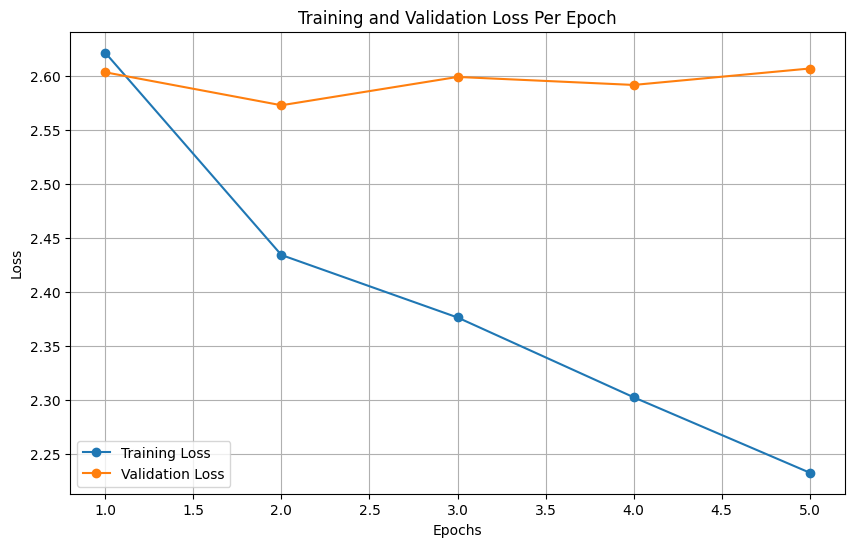

In [86]:
import matplotlib.pyplot as plt

# Epochs
epochs = [1, 2, 3, 4, 5]

# Training and validation losses
train_losses = [2.6214, 2.4343, 2.3765, 2.3027, 2.2329] # TODO manually input
val_losses = [2.6033, 2.5728, 2.5990, 2.5916, 2.6068] # TODO

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')

# Adding titles and labels
plt.title('Training and Validation Loss Per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

## Evaluation on Test dataset

In [109]:
# @title load model
import os
from google.colab import drive
drive.mount('/content/drive')
from transformers import RobertaModel, RobertaConfig
# Make sure to replace 'path_to_model' with the actual path to your .pt file
model_path = '/content/drive/MyDrive/11711/Project_4/Checkpoints_train_join_full/model_epoch_5.pt'

# Initialize the model architecture (make sure this matches the architecture used during training)
# For instance, if you used a specific configuration or a model for a specific task like RobertaForSequenceClassification,
# you should initialize that specific model with the same configuration.
loaded_model = RobertaForSequenceClassification(config=roberta_config).cuda()
loaded_model = nn.DataParallel(loaded_model.cuda())

# Load the state dictionary
state_dict = torch.load(model_path, map_location=torch.device('cpu'))

# Apply the state dictionary to the model
loaded_model.load_state_dict(state_dict)
model = loaded_model

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [110]:
def evaluate(model_, eval_loader):
    model.eval()
    dict_result = {'actual':[],
                   'preds':[]}
    with torch.no_grad():
        for batch in tqdm(eval_loader):
            outputs = model(**batch)
            logits = outputs[1]

            dict_result['actual'] += batch['labels'].numpy().tolist()
            dict_result['preds'] += np.argmax(logits.detach().cpu().numpy(), axis=1).tolist()
    return dict_result

In [111]:
dict_test_results = evaluate(model_=model,
                             eval_loader=test_loader)

100%|██████████| 252/252 [00:52<00:00,  4.81it/s]


In [112]:
# @title evaluation model
from sklearn.metrics import classification_report
from collections import Counter
from tqdm import tqdm

def get_performance(actual_og, preds_og, dict_mapping, avoid_labels=[]):
    actual_og = [x[0] for x in actual_og]
    actual_ = []
    preds_ = []

    # Filter out specified labels
    for ind in tqdm(range(len(actual_og))):
        if actual_og[ind] not in avoid_labels and preds_og[ind] not in avoid_labels:
            actual_.append(actual_og[ind])
            preds_.append(preds_og[ind])

    # Get unique labels present after filtering
    unique_labels = sorted(set(actual_ + preds_))

    # Create target_names for only the present labels
    target_names = [dict_mapping[label] for label in unique_labels if label in dict_mapping]

    # Generate classification report
    print()
    df_report = classification_report(actual_, preds_, labels=unique_labels, target_names=target_names, output_dict=False)
    print(df_report)

    # Print additional stats
    print('--'*20)
    print('STATS')
    print('--'*20)
    print('Actual counter:', Counter(actual_))
    print('Prediction counter:', Counter(preds_))
    print('Mapping:', dict_mapping)

    return df_report


In [113]:
df_test = get_performance(actual_og=dict_test_results['actual'],
                          preds_og=dict_test_results['preds'],
                          dict_mapping=id2label)

100%|██████████| 16070/16070 [00:00<00:00, 1391434.22it/s]


                precision    recall  f1-score   support

    admiration       0.00      0.00      0.00       123
     amusement       0.00      0.00      0.00        99
         anger       0.24      0.27      0.25      1458
     annoyance       0.00      0.00      0.00       227
      approval       0.00      0.00      0.00       106
        caring       0.00      0.00      0.00       102
     confusion       0.00      0.00      0.00       203
     curiosity       0.12      0.01      0.01       321
        desire       0.00      0.00      0.00       102
disappointment       0.00      0.00      0.00       189
   disapproval       0.12      0.01      0.01       198
       disgust       0.16      0.01      0.03       294
 embarrassment       0.00      0.00      0.00       215
    excitement       0.00      0.00      0.00        85
          fear       0.29      0.02      0.03       502
     gratitude       0.17      0.08      0.11       127
         grief       0.16      0.13      0.14 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
